## Global ocean ventilation

* This notebook ...
* Author: Henri Drake (modified from John Dunne's ferret script: `/net/jpd/ESM4.5/esm4.5_vent_analysis.jnl`)

In [348]:
config = {
    "startyr": None,
    "endyr": None,
    "dora_id": "odiv-413",
    "pathPP": None,
}

In [349]:
plot_obs = False

In [351]:
# Make sure this cell is active so that the workflow and Dora can update
# the config dictionary at runtime.

from gfdlnb.tools.update_notebook_config import update_notebook_config
config = update_notebook_config(config)

In [352]:
print(str(config))

{'startyr': None, 'endyr': None, 'dora_id': 'odiv-413', 'pathPP': None}


In [353]:
import os
import datetime

### Import Python Modules

In [354]:
import glob
import subprocess

import doralite
import matplotlib.pyplot as plt
import momgrid as mg
import momlevel as ml
import numpy as np
import xarray as xr

In [355]:
# momgrid will use a directory of pre-computed weights
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Define Local Parameters

In [357]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

if config["dora_id"] is not None:
    experiment =  doralite.dora_metadata(config["dora_id"])
    pathPP = experiment["pathPP"]
    expName = experiment["expName"]
else:
    raise ValueError("Experiment must be defined")

# Define start and end years
start = config["startyr"]
start = int(start) if start is not None else 1

end = config["endyr"]
end = int(end) if end is not None else 9999

### Determine What Files to Load

In [358]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_annual_z"
static = f"{component}/{component}.static.nc"
varname = "ann"

chunk = "annual_5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/av/{chunk}/{component}.*.{varname}.nc", recursive=True))

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.0001-0005.ann.nc
/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.0006-0010.ann.nc
/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.0011-0015.ann.nc
/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.0016-0020.ann.nc
/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.0021-0025.ann.nc
/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_annual_z/av

### DMgetting Files

Dora cannot issue calls to dmget

In [359]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+[staticfile]
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Establish a Dictionary to Store Scalar Metrics

In [360]:
stats_dict = {}
stats_dict["metadata"] = {
    "expName": str(expName),
    "created": datetime.datetime.now().isoformat(),
}
stats_dict["results"] = {}
stats_dict

{'metadata': {'expName': 'CM4.5v01_om5b06_piC_noBLING',
  'created': '2024-10-17T14:24:26.454212'},
 'results': {}}

### Load model data and grid

In [370]:
# Try first to load a symmetric grid. Older CM4/OM4 runs may need non-symmetric
try:
    ds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
except:
    ds = momgrid.Gridset(filelist, force_symmetric=False, return_corners=True)

model_type = ds.model
ds = ds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))

ds["dz"] = xr.DataArray(ds.z_i.diff("z_i").values, dims=("z_l",))

RuntimeError: Cannot associate grid to data. Different dims: ['xq', 'yq']

### Estimate cross-sectional area

In [ ]:
from xhistogram.xarray import histogram

In [364]:
def vent(ds):
    max_age = ds.agessc.max(["xh", "yh", "z_l"])
    max_age = max_age.where(max_age > 0, 1.e-12)
    return (max_age - ds.agessc)/max_age

def obs_zonal_vertical_integral(da, dxdz, depth_range=[0, np.inf]):
    return (da*dxdz).sum(["longitude", "depth"])

def model_ventilation_inventory(ds, depth_range=[0, np.inf]):
    # Broadcast geolat so that argument for histogram has same dimensions as the weights
    _, geolat = xr.broadcast(ds.agessc, ds.geolat)
    geolat = geolat.rename("latitude")

    # Target coordinate bins
    dphi = 1.
    lat_bins = xr.DataArray(np.arange(-90, 91, dphi), dims=("latitude_bins",))

    # To accomodate the bipolar Arctic grid, instead of integrating along *nominal* longitude variable `xh`,
    # we use xhistogram to do a weighted sum in latitude bins. Because we don't have the correct
    # longitudinal widths of each grid cell, we over-weight the integral by `areacello` and then divide by the 
    # meridional width of each latitude band.
    weights = vent(ds)*ds.areacello*ds.dz
    ventilation_inventory_overweighted = histogram(
        geolat,
        bins=lat_bins.values,
        weights=weights.fillna(0.),
        dim=["xh", "z_l", "yh"],
        bin_dim_suffix="",
        block_size=None
    )
    R = 6378e3
    meridional_arc_length = (2*np.pi/360) * dphi * R * np.cos(np.deg2rad(ventilation_inventory_overweighted.latitude))
    ventilation_inventory = ventilation_inventory_overweighted / meridional_arc_length
    return ventilation_inventory
    

In [ ]:
vent(ds).isel(time=1, xh=1100).plot()

In [ ]:
model_zonal_vertical_integral(ds).isel(time=0).plot()
model_zonal_vertical_integral(ds).isel(time=1).plot()

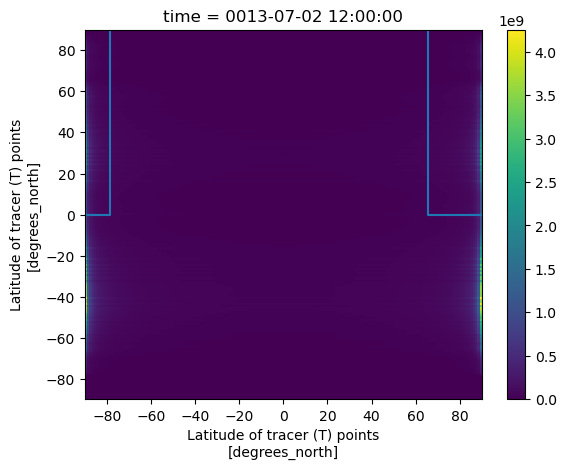

In [279]:
(obs_zonal_vertical_integral(obs.pCFC12, obs.dxdz)/350).plot()
model_zonal_vertical_integral(ds).isel(time=0).plot()

In [166]:
np.logical_not(np.isnan(vent(ds)))

<xarray.DataArray (time: 2, z_l: 35, yh: 1080, xh: 1440)> Size: 871MB
dask.array<mul, shape=(2, 35, 1080, 1440), dtype=float64, chunksize=(1, 35, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 16B 0013-07-02 12:00:00 0018-07-02 12:00:00
  * z_l        (z_l) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * xh         (xh) float64 12kB 0.5 1.5 2.5 ... 1.438e+03 1.438e+03 1.44e+03
  * yh         (yh) float64 9kB 0.5 1.5 2.5 3.5 ... 1.078e+03 1.078e+03 1.08e+03
    geolon     (yh, xh) float32 6MB -299.7 -299.5 -299.2 ... 60.0 60.0 60.0
    geolat     (yh, xh) float32 6MB -79.81 -79.81 -79.8 ... 64.33 64.22 64.11
    areacello  (yh, xh) float32 6MB 3.436e+07 3.434e+07 ... 2.686e+06 1.503e+06

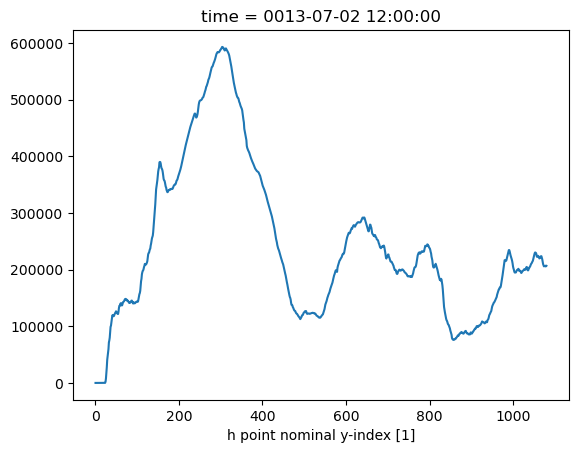

In [158]:
(vent(ds)*ΔA).sum(["xh", "z_l"]).isel(time=0).plot()

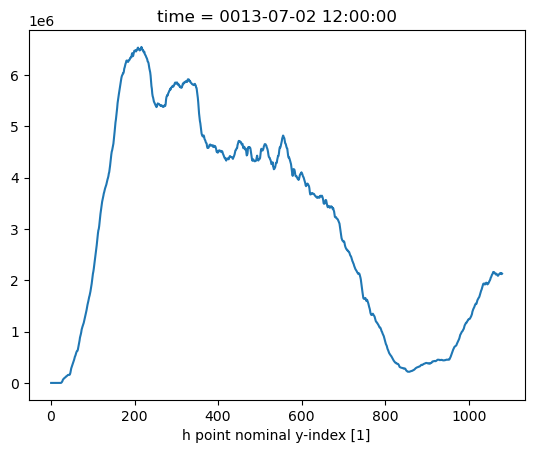

In [161]:
(np.logical_not(np.isnan(vent(ds)))*ΔA).isel(time=0).sum(["xh", "z_l"]).plot()

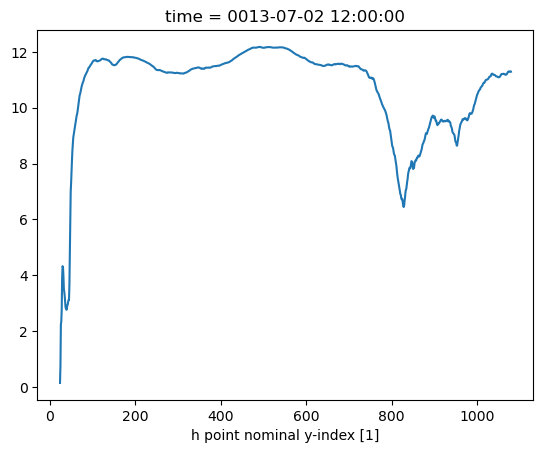

In [173]:
weighted_zonal_vertical_mean(ds.agessc, ΔA).isel(time=0).plot()

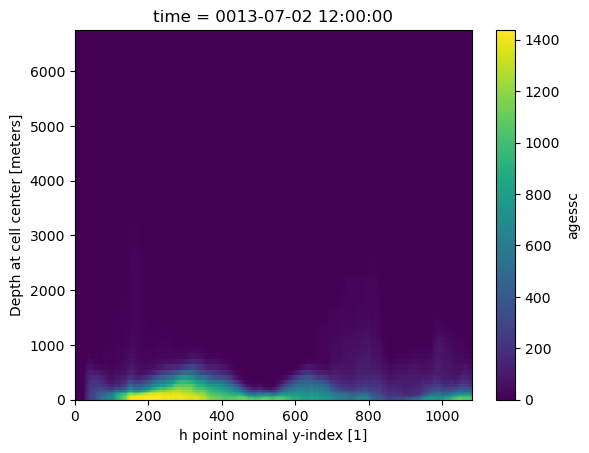

In [156]:
vent(ds).isel(time=0).sum("xh").plot()

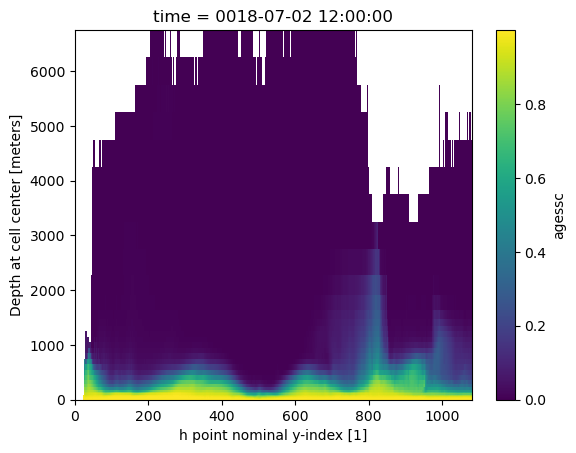

In [123]:
zonal_mean(vent(ds)).isel(time=-1).plot()

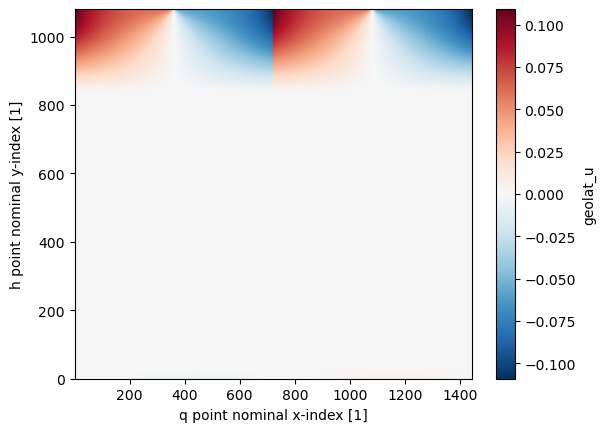

In [107]:
ds.geolat_u.diff("xq").plot()

In [169]:
Δz = ds.z_i.diff("z_i").rename({"z_i":"z_l"})
Δz = Δz.assign_coords({"z_l": ds.z_l})
Δx = 1 # arbitrary constant since x-cells are uniformly spaced
ΔA = Δz * Δx

In [205]:
obs = xr.open_dataset("/net/jpd/glodap/pCFC12.nc")

# Add grid metrics
obs = obs.assign_coords({"z_i": xr.DataArray(
    np.concatenate([np.array([0]), (obs["depth"][:-1].values + obs["depth"][1:].values) / 2., np.array([5750])]),
    dims = ("z_i",)
)})
obs["dz"] = xr.DataArray(obs.z_i.diff("z_i").values, dims=("depth",))
R = 6378e3
dlambda = 1.
obs["dx"] = (2*np.pi*R/360)*dlambda*np.cos(np.deg2rad(obs.latitude))
obs["dxdz"] = obs.dx*obs.dz

obs

<xarray.Dataset> Size: 17MB
Dimensions:    (longitude: 360, latitude: 180, depth: 33, z_i: 34)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth      (depth) float64 264B 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * z_i        (z_i) float64 272B 0.0 5.0 15.0 ... 4.75e+03 5.25e+03 5.75e+03
Data variables:
    pCFC12     (depth, longitude, latitude) float32 9MB ...
    pCFC12Err  (depth, longitude, latitude) float32 9MB ...
    dz         (depth) float64 264B 5.0 10.0 10.0 15.0 ... 500.0 500.0 500.0
    dx         (latitude) float64 1kB 971.4 2.914e+03 ... 2.914e+03 971.4
    dxdz       (latitude, depth) float64 48kB 4.857e+03 9.714e+03 ... 4.857e+05
Attributes:
    title:          Gridded pCFC-12 Data
    authors:        Bob Key
    creation_date:  Jul 28 10:11, 2003

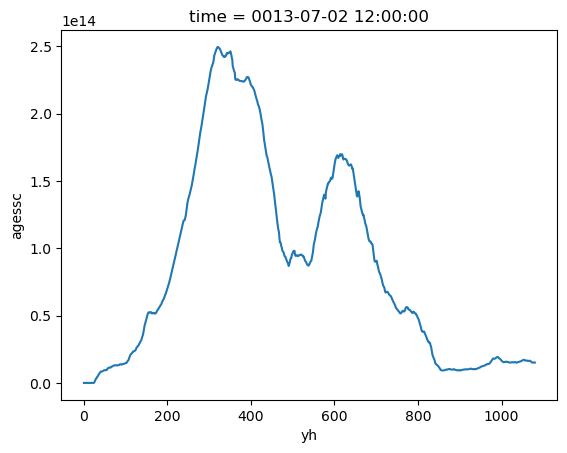

/nbhome/ogrp/python/envs/py311_20240923/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/ogrp/python/envs/py311_20240923/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [99]:
vent(ds).weighted(ΔV).sum(["xh", "z_l"]).isel(time=0).plot()

In [14]:
zeta = 0.0
coriolis = ml.derived.calc_coriolis(ds.geolat)
n2 = ml.derived.calc_n2(ds.thetao, ds.so)
pv = ml.derived.calc_pv(zeta, coriolis, n2, interp_n2=False, units="cm")
pv = pv.transpose("z_l", "yh", "xh")
pv = pv.load()

In [15]:
levels, colors = ml.util.get_pv_colormap()

In [16]:
pv = mg.geoslice.geoslice(pv, x=(-180,-120),y=(-65,0))

In [17]:
yindex = pv.geolat.mean("xh")

### Calcualte the Volume

In [18]:
if "volcello" in ds.keys():
    volcello = mg.geoslice.geoslice(ds.volcello, x=(-180,-120),y=(-65,0))
    volume = xr.where(pv > 60.0, volcello, np.nan).sel(z_l=slice(700, None)).sum()
    volume = volume.load()
    print(f"Volume of water with PV > 60 cm-2 s-1: {float(volume)}")
    stats_dict["results"] = {"volume": float(volume)}
else:
    stats_dict["results"] = {"volume": 0.}

### Make zonal mean plot

In [19]:
# Take the zonal mean
pv = pv.weighted(ds.areacello).mean("xh")

In [20]:
pv = pv.transpose("z_l", "yh")

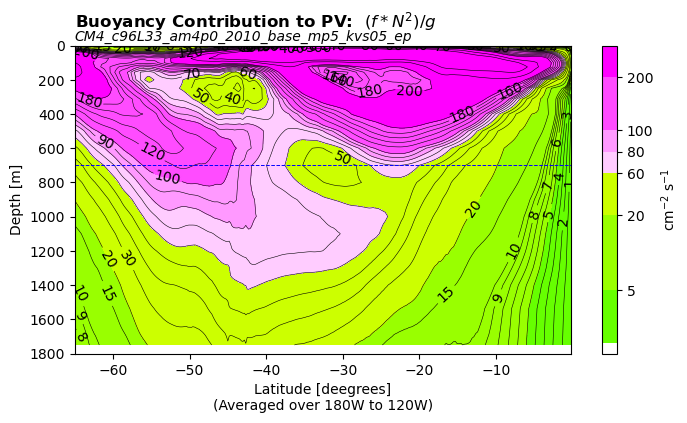

In [21]:
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = plt.subplot(1, 1, 1)
cb = ax.contourf(yindex, pv.z_l, pv, levels=levels, colors=colors)
cs = ax.contour(yindex, pv.z_l, pv, levels=levels, colors=["k"], linewidths=0.4)
ax.set_ylim(0, 1800.0)
ax.invert_yaxis()

_ = ax.set_xlabel("Latitude [deegrees]\n(Averaged over 180W to 120W)")
_ = ax.set_ylabel("Depth [m]")

ax.hlines(
    700, yindex.min(), yindex.max(), colors="blue", linestyles="dashed", linewidths=0.7
)

ax.clabel(cs)

_ = ax.text(
    0.0,
    1.06,
    r"Buoyancy Contribution to PV:  $(f * N^2)/g$",
    transform=ax.transAxes,
    fontsize=12,
    weight="bold",
)

_ = ax.text(
    0.0,
    1.015,
    expName,
    transform=ax.transAxes,
    fontsize=10,
    style="italic",
)

plt.colorbar(cb, ticks=[5, 20, 60, 80, 100, 200], label=r"cm$^{-2}$ s$^{-1}$")

### Plot Observations

In [22]:
if plot_obs:
    dsobs = xr.open_dataset(
        "/archive/jpk/datasets/OM5/obs/RG_ArgoClim/RG_ArgoClim_TS.200401-201812.nc"
    )
    dsobs = dsobs.sel(xh=slice(180, 240)).sel(yh=slice(None, 0))

    zeta = 0.0
    coriolis = ml.derived.calc_coriolis(dsobs.geolat)
    n2 = ml.derived.calc_n2(dsobs.thetao, dsobs.so)
    pv = ml.derived.calc_pv(zeta, coriolis, n2, interp_n2=False, units="cm")
    pv = pv.transpose("z_l", "yh", "xh")

    # Infer cell bounds
    lat = pv.geolat[:, 0].values
    lon = pv.geolon[0, :].values
    lat_b = mg.util.infer_bounds(lat)
    lon_b = mg.util.infer_bounds(lon)

    # Calculate cell area
    area = mg.util.standard_grid_area(lat_b, lon_b)
    area = xr.DataArray(area, dims=("yh", "xh"), coords={"yh": pv.yh, "xh": pv.xh})

    # Calculate cell volume
    depth = (area * 0.0) + dsobs.z_i[-1]
    dz = ml.derived.calc_dz(dsobs.z_l, dsobs.z_i, depth)
    volcello = dz * area

    # Volume of high-PV water
    volume = xr.where(pv > 60.0, volcello, np.nan).sel(z_l=slice(700, None)).sum()

    print(f"Volume of water with PV > 60 cm-2 s-1: {float(volume)}")

    # Take the zonal mean
    pv = pv.weighted(area).mean("xh")

    fig = plt.figure(figsize=(8, 4), dpi=100)
    ax = plt.subplot(1, 1, 1)
    cb = ax.contourf(dsobs.yh, dsobs.z_l, pv, levels=levels, colors=colors)
    cs = ax.contour(
        dsobs.yh, dsobs.z_l, pv, levels=levels, colors=["k"], linewidths=0.4
    )
    ax.set_ylim(0, 1800.0)
    # ax.set_xlim(None,0)
    ax.invert_yaxis()

    _ = ax.set_xlabel("Latitude [deegrees]\n(Averaged over 180W to 120W)")
    _ = ax.set_ylabel("Depth [m]")

    ax.hlines(
        700,
        pv.yh.min(),
        pv.yh.max(),
        colors="blue",
        linestyles="dashed",
        linewidths=0.7,
    )

    ax.clabel(cs)

    _ = ax.text(
        0.0,
        1.06,
        r"Buoyancy Contribution to PV:  $(f * N^2)/g$",
        transform=ax.transAxes,
        fontsize=12,
        weight="bold",
    )

    _ = ax.text(
        0.0,
        1.015,
        r"Roemmich and Gilson Gridded Argo Climatology - 2004 to 2018",
        transform=ax.transAxes,
        fontsize=10,
        style="italic",
    )

    plt.colorbar(cb, ticks=[5, 20, 60, 80, 100, 200], label=r"cm$^{-2}$ s$^{-1}$")

### Write Stats to a File

In [23]:
if not "DORA_EXECUTE" in os.environ.keys():
    import yaml
    yml = yaml.dump(stats_dict)
    with open('aaiw_pv.yaml', 'w') as file:
        file.write(yml)
    file.close()
    print(yml)

metadata:
  created: '2024-10-08T13:34:23.401643'
  expName: CM4_c96L33_am4p0_2010_base_mp5_kvs05_ep
results:
  volume: 0.0

